In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

In [2]:
df = pd.read_csv("../toydata/titanic.csv")
print(f"{df.shape}")
print(df.iloc[0,:].to_string())

(891, 15)
survived                 0
pclass                   3
sex                   male
age                   22.0
sibsp                    1
parch                    0
fare                  7.25
embarked                 S
class                Third
who                    man
adult_male            True
deck                   NaN
embark_town    Southampton
alive                   no
alone                False


### signal calc

In [3]:
def calculate_signal(
    df,
    col,
    target_col,
    seg_col=None,
    exposure_col=None,
    exposure_on_target_too=True,
):

    df = df.copy()

    # placeholder col for segment column
    if seg_col is None:
        seg_col = "_seg"
        if seg_col in df.columns:
            raise ValueError(f"Column '{seg_col}' is reserved, change column name.")
        df[seg_col] = "all"

    # aggregate
    agg_dict = {}
    agg_dict["count"] = (target_col, np.size)
    agg_dict[target_col] = (target_col, "sum")
    if exposure_col is not None:
        agg_dict[exposure_col] = (exposure_col, "sum")

        if exposure_on_target_too:
            tar_exp = f"{target_col}_{exposure_col}"
            df[tar_exp] = df[target_col].mul(df[exposure_col])
            agg_dict[tar_exp] = (tar_exp, "sum")

    _ = df.groupby([seg_col, col], dropna=False, observed=False)
    _ = _.agg(**agg_dict)

    # count dist
    grps = _.groupby(seg_col, dropna=False, observed=False)
    for name, group in grps:
        group["count_dist"] = group["count"].div(group["count"].sum())
        _.loc[group.index,["count_dist"]] = group[["count_dist"]]

    # rates
    grps = _.groupby(seg_col, dropna=False, observed=False)
    for name, group in grps:
        group[f"{target_col}_dist"] = group[target_col].div(group[target_col].sum())
        group[f"{target_col}_rate"] = group[target_col].div(group["count"])
        _.loc[group.index,[f"{target_col}_dist", f"{target_col}_rate"]] = group[[f"{target_col}_dist", f"{target_col}_rate"]]

    # exp rates
    if exposure_col is not None:
        grps = _.groupby(seg_col, dropna=False, observed=False)
        for name, group in grps:
            group[f"{tar_exp}_dist"] = group[tar_exp].div(group[tar_exp].sum())
            group[f"{tar_exp}_rate"] = group[tar_exp].div(group[exposure_col])

            _.loc[group.index,[f"{tar_exp}_dist", f"{tar_exp}_rate"]] = group[[f"{tar_exp}_dist", f"{tar_exp}_rate"]]

    if seg_col == "_seg":
        _.index = _.index.droplevel(0)

    return _

In [19]:
# example
edges = [-np.inf, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, np.inf]
df["age_binned"] = pd.cut(df["age"], bins=edges, right=False)
df2 = calculate_signal(df, target_col="survived", col="age_binned", exposure_col="fare")
df2

,count,survived,fare,survived_fare,count_dist,survived_dist,survived_rate,survived_fare_dist,survived_fare_rate
age_binned,,,,,,,,,
"[-inf, 0.0)",NaN,0,0.0000,0.0000,NaN,0.000000,NaN,0.000000,NaN
"[0.0, 10.0)",62.0,38,1895.7541,1051.3458,0.069585,0.111111,0.612903,0.063521,0.554579
"[10.0, 20.0)",102.0,41,3318.5835,1948.8835,0.114478,0.119883,0.401961,0.117749,0.587264
"[20.0, 30.0)",220.0,77,6001.3662,3161.3833,0.246914,0.225146,0.350000,0.191006,0.526777
"[30.0, 40.0)",167.0,73,6743.0081,5071.8250,0.187430,0.213450,0.437126,0.306432,0.752161
"[40.0, 50.0)",89.0,34,3382.2044,2030.3128,0.099888,0.099415,0.382022,0.122668,0.600293
"[50.0, 60.0)",48.0,20,2300.8000,1408.2833,0.053872,0.058480,0.416667,0.085086,0.612084
"[60.0, 70.0)",19.0,6,918.9833,332.4958,0.021324,0.017544,0.315789,0.020089,0.361808
"[70.0, 80.0)",6.0,0,181.1834,0.0000,0.006734,0.000000,0.000000,0.000000,0.000000


In [4]:
# example
df = df
col ="who"
target_col="survived"
seg_col ="sex"
# seg_col = None
exposure_col = "fare"
exposure_on_target_too = True
df2 = calculate_signal(df, target_col=target_col, col=col, seg_col=seg_col, exposure_col=exposure_col)
df2

count  survived        fare  survived_fare  count_dist  \
sex    who                                                             
female child     43        28   1346.0001       864.8584    0.136943   
       woman    271       205  12620.6627     11236.8292    0.863057   
male   child     40        21   1375.2209       746.8167    0.069324   
       man      537        88  13352.0656      3702.7251    0.930676   

              survived_dist  survived_rate  survived_fare_dist  \
sex    who                                                       
female child       0.120172       0.651163            0.071466   
       woman       0.879828       0.756458            0.928534   
male   child       0.192661       0.525000            0.167841   
       man         0.807339       0.163873            0.832159   

              survived_fare_rate  
sex    who                        
female child            0.642540  
       woman            0.890352  
male   child            0.543052  
       man              0.277315

In [11]:
# example
edges = [-np.inf, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, np.inf]
df["age_binned"] = pd.cut(df["age"], bins=edges, right=False)
df2 = calculate_signal(df, target_col="survived", col="age_binned", seg_col="class", exposure_col="fare")
df2

count  survived       fare  survived_fare  count_dist  \
class  age_binned                                                             
First  [-inf, 0.0)      NaN         0     0.0000         0.0000         NaN   
       [0.0, 10.0)      3.0         2   384.9583       233.4083    0.013889   
       [10.0, 20.0)    18.0        15  2053.9125      1628.9125    0.083333   
       [20.0, 30.0)    34.0        24  3454.5291      2325.9667    0.157407   
       [30.0, 40.0)    50.0        39  4917.2167      4426.7334    0.231481   
       [40.0, 50.0)    37.0        22  2515.4502      1770.3378    0.171296   
       [50.0, 60.0)    27.0        15  2014.2208      1322.2833    0.125000   
       [60.0, 70.0)    13.0         4   835.4083       312.4083    0.060185   
       [70.0, 80.0)     3.0         0   155.1584         0.0000    0.013889   
       [80.0, 90.0)     1.0         1    30.0000        30.0000    0.004630   
       [90.0, 100.0)    NaN         0     0.0000         0.0000         NaN   
       [100.0, inf)     NaN         0     0.0000         0.0000         NaN   
       nan             30.0        14  1816.5582       952.6416    0.138889   
Second [-inf, 0.0)      NaN         0     0.0000         0.0000         NaN   
       [0.0, 10.0)     17.0        17   488.5834       488.5834    0.092391   
       [10.0, 20.0)    18.0         9   376.8208       170.5708    0.097826   
       [20.0, 30.0)    53.0        22  1180.4750       490.6292    0.288043   
       [30.0, 40.0)    48.0        19   941.5750       356.3500    0.260870   
       [40.0, 50.0)    18.0        10   416.2500       244.0000    0.097826   
       [50.0, 60.0)    15.0         5   240.3750        86.0000    0.081522   
       [60.0, 70.0)     3.0         1    60.0000        10.5000    0.016304   
       [70.0, 80.0)     1.0         0    10.5000         0.0000    0.005435   
       [80.0, 90.0)     NaN         0     0.0000         0.0000         NaN   
       [90.0, 100.0)    NaN         0     0.0000         0.0000         NaN   
       [100.0, inf)     NaN         0     0.0000         0.0000         NaN   
       nan             11.0         4    87.2625        72.2125    0.059783   
Third  [-inf, 0.0)      NaN         0     0.0000         0.0000         NaN   
       [0.0, 10.0)     42.0        19  1022.2124       329.3541    0.085540   
       [10.0, 20.0)    66.0        17   887.8502       149.4002    0.134420   
       [20.0, 30.0)   133.0        31  1366.3621       344.7874    0.270876   
       [30.0, 40.0)    69.0        15   884.2164       288.7416    0.140530   
       [40.0, 50.0)    34.0         2   450.5042        15.9750    0.069246   
       [50.0, 60.0)     6.0         0    46.2042         0.0000    0.012220   
       [60.0, 70.0)     3.0         1    23.5750         9.5875    0.006110   
       [70.0, 80.0)     2.0         0    15.5250         0.0000    0.004073   
       [80.0, 90.0)     NaN         0     0.0000         0.0000         NaN   
       [90.0, 100.0)    NaN         0     0.0000         0.0000         NaN   
       [100.0, inf)     NaN         0     0.0000         0.0000         NaN   
       nan            136.0        34  2018.2456       491.8458    0.276986   

                      survived_dist  survived_rate  survived_fare_dist  \
class  age_binned                                                        
First  [-inf, 0.0)         0.000000            NaN            0.000000   
       [0.0, 10.0)         0.014706       0.666667            0.017951   
       [10.0, 20.0)        0.110294       0.833333            0.125275   
       [20.0, 30.0)        0.176471       0.705882            0.178883   
       [30.0, 40.0)        0.286765       0.780000            0.340447   
       [40.0, 50.0)        0.161765       0.594595            0.136152   
       [50.0, 60.0)        0.110294       0.555556            0.101693   
       [60.0, 70.0)        0.029412       0.307692            0.024026   
       [70.0, 80.0)        0.000000       

### binning

In [ ]:
# auto histogram binning
edges = np.histogram_bin_edges(df["age"].dropna(), bins=4)
df["age_binned"] = pd.cut(df["age"], bins=edges, right=False)

In [ ]:
# specified
edges = [-np.inf, 0, 20, 40, 100, np.inf]
df["age_binned"] = pd.cut(df["age"], bins=edges, right=False)

In [ ]:
# condition
idx = df.eval("parch >= 3")
df["parch_binned"] = df["parch"].astype(str)
df.loc[idx, "parch_binned"] = "3+"

### single plots 

In [27]:
def plot_one_bar_and_line(df, col, target_col, rotation=0, y_lim=(None,), ax2_y_lim=(None,), figsize = (7.5, 5),ax=None):
    df2 = df.copy()

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()
    
    index = df2.index
    title = f"{col} & {target_col} by {index.name}"
    x_ticks = index.astype(str)

    ax.bar(x_ticks, df2[col])
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticks, rotation=rotation)
    ax.set_xlabel(index.name)
    ax.set_ylabel(col, loc="center")
    ax.set_ylim(*y_lim)
    ax.set_title(title)

    ax2 = ax.twinx()
    ax2.plot(x_ticks, df2[target_col], color="red",marker="o")
    ax2.set_ylabel(target_col, loc="bottom")
    ax2.set_ylim(*ax2_y_lim)

    return fig, ax, ax2

In [23]:
df2[target_col]

age_binned
[-inf, 0.0)           NaN
[0.0, 10.0)      0.612903
[10.0, 20.0)     0.401961
[20.0, 30.0)     0.350000
[30.0, 40.0)     0.437126
[40.0, 50.0)     0.382022
[50.0, 60.0)     0.416667
[60.0, 70.0)     0.315789
[70.0, 80.0)     0.000000
[80.0, 90.0)     1.000000
[90.0, 100.0)         NaN
[100.0, inf)          NaN
NaN              0.293785
Name: survived_rate, dtype: float64

(<Figure size 750x500 with 2 Axes>,
 <Axes: title={'center': 'count & survived_rate by age_binned'}, xlabel='age_binned', ylabel='count'>,
 <Axes: ylabel='survived_rate'>)

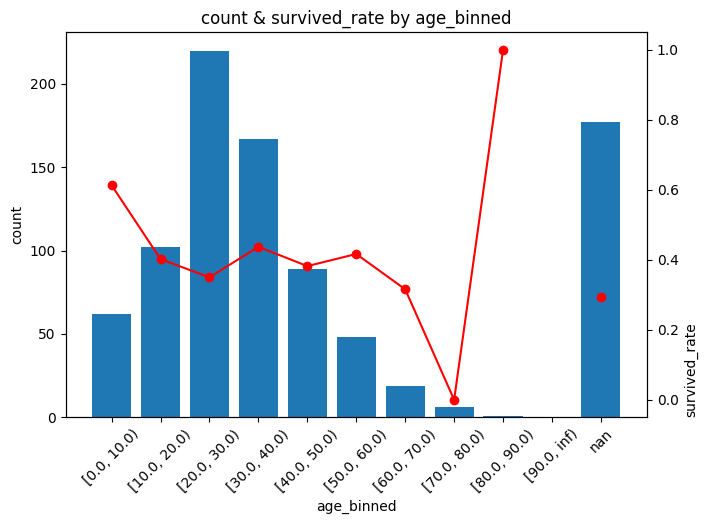

In [28]:
# example
edges = [-np.inf, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, np.inf]
df["age_binned"] = pd.cut(df["age"], bins=edges, right=False)
df2 = calculate_signal(df, target_col="survived", col="age_binned", exposure_col="fare")

col="count"
target_col="survived_rate"
rotation=45
y_lim=(None,)
ax2_y_lim=(None,)

plot_one_bar_and_line(
    df2,
    col=col,
    target_col=target_col,
    rotation=rotation,
    y_lim=y_lim,
    ax2_y_lim=ax2_y_lim,
)

### multi - plots

In [5]:
def plot_bar_and_line(
    df, col, target_col, rotation=0, y_lim=(None,), y_lim2=(None,), ax2_y_lim=(None,), figsize = (15, 5),
):

    df2 = df.copy()

    # add dummy index for single level
    if df2.index.nlevels == 1:
        df2.index = pd.MultiIndex.from_product([["all"], df2.index], names=["all", df2.index.name])
    elif len(df2.index.levels) > 2:
        raise ValueError(f"index levels in input can only be 1 or 2, {df2.index.levels = }")

    # plot for each segment
    segs = df2.index.levels[0]

    for seg in segs:

        df3 = df2.loc[seg,:]

        fig, ax = plt.subplots(1, 2, figsize=figsize)
        
        if segs.size > 1:
            fig.suptitle(f"{seg}", fontsize=16)

        def plot_1_chart(ax, word, y_lim=(None,), ax2_y_lim=(None,), chart_word1=""):

            index = df3.index
            title = f"{chart_word1} & {target_col} of {index.name}"
            x_ticks = index.astype(str)

            ax.bar(x_ticks, df3[word])
            ax.set_xticks(x_ticks)
            ax.set_xticklabels(x_ticks, rotation=rotation)
            ax.set_xlabel(index.name)
            ax.set_ylabel(word, loc="center")
            ax.set_ylim(*y_lim)
            ax.set_title(title)

            ax2 = ax.twinx()
            ax2.plot(x_ticks, df3[target_col], color="red")
            ax2.set_ylabel(target_col, loc="bottom")
            ax2.set_ylim(*ax2_y_lim)

        plot_1_chart(ax[0], col, y_lim=y_lim, ax2_y_lim=ax2_y_lim, chart_word1=col.capitalize())
        plot_1_chart(ax[1], f"{col}_dist", y_lim=y_lim2, ax2_y_lim=ax2_y_lim, chart_word1="Distribution of " + col.capitalize())

    plt.show()
    

In [ ]:
col="count"
target_col="survived_rate"
rotation=0
y_lim=(None,)
y_lim2=(None,)
ax2_y_lim=(None,)
figsize = (15, 5)

plot_bar_and_line(
    df2,
    col=col,
    target_col=target_col,
    rotation=rotation,
    y_lim=y_lim,
    y_lim2=y_lim2,
    ax2_y_lim=ax2_y_lim
)

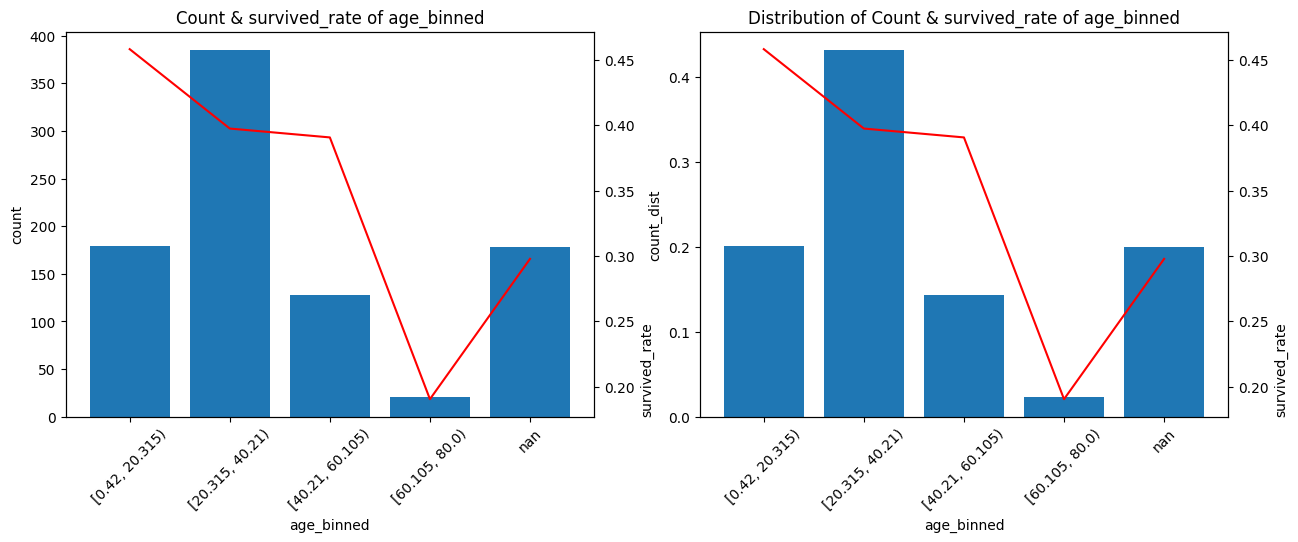

,count,survived,count_dist,survived_dist,survived_rate
age_binned,,,,,
"[0.42, 20.315)",179,82,0.20,0.24,0.46
"[20.315, 40.21)",385,153,0.43,0.45,0.40
"[40.21, 60.105)",128,50,0.14,0.15,0.39
"[60.105, 80.0)",21,4,0.02,0.01,0.19
NaN,178,53,0.20,0.15,0.30


In [ ]:
edges = np.histogram_bin_edges(df["age"].dropna(), bins=4)
df["age_binned"] = pd.cut(df["age"], bins=edges, right=False)

_ = calculate_signal(df, target_col="survived", col="age_binned")
plot_bar_and_line(_, col="count",target_col="survived_rate", rotation=45)
_.round(2)